In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utility as ut
import numpy as np #needed for dummy datasets only
import os #needed for join path and filenames when saving plots
from matplotlib.gridspec import GridSpec

plt.style.use('delight.mplstyle')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ModuleNotFoundError: No module named 'utility'

## MMC analysis trace

In [2]:
xs, trace, fitted_trace = np.load('/home/ws/ks0116/software/processor/trace_fitted.npy')
residuals = trace - fitted_trace

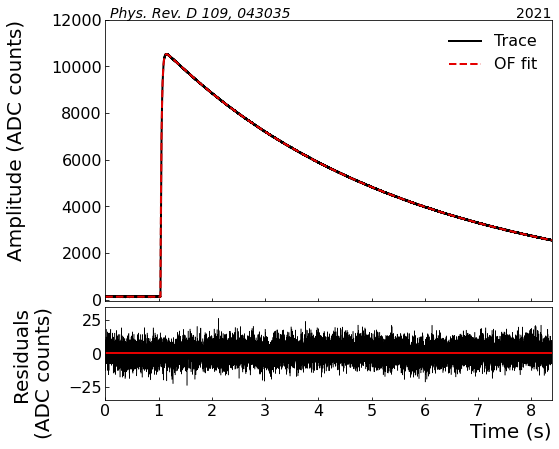

In [148]:
# Set up figure and subplots
fig = plt.figure(figsize=(8, 7))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.03)

# Top plot (data)
ax1 = fig.add_subplot(gs[0])
ax1.plot(xs, trace, '-', label="Trace", color='xkcd:black', lw=2.)
ax1.plot(xs, fitted_trace, '--', label="OF fit", color='xkcd:red')

ax1.set_xlim(0, np.max(xs))
ax1.set_ylim(-50, 1.2e4)
ax1.set_ylabel(r'Amplitude (ADC counts)', ha='right', y=1.0, labelpad=25) #adjust labelpad manually, pixel precision is near impossible in mpl
ax1.tick_params(labelbottom=False) #hide the axis labels in top plot

# Add legend to top plot
ax1.legend()

# display text
# ut.display_delight_text(ax1, x0=0.04, y0=1.045)
ax1.text(0.01, 1.045, 'Phys. Rev. D 109, 043035', transform=ax1.transAxes,
         fontsize=14, color='black', alpha=1.0, style='italic',
         ha='left', va='top', rotation=0, zorder=10)
# ut.display_text(ax1, 'Phys. Rev. D 109, 043035', x0=0.01, y0=1.045)

# display data taking period
ut.display_text(ax1, '2021', x0=1.0, y0=1.045, ha='right')

# Bottom plot (residuals - difference from the mean)
y_range=(-35., 35.)
y_arrows=np.array(y_range) / 1.5

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(xs, residuals, '-', color='xkcd:black', lw=0.5)

ax2.set_xlabel(r'Time (s)', ha='right', x=1.0)
ax2.set_ylabel("Residuals\n(ADC counts)", labelpad=15, ha='right', y=1.0)  #adjust labelpad manually, pixel precision is near impossible in mpl
ax2.set_ylim(y_range)

ax2.axhline(0, color='xkcd:red', linestyle='-', linewidth=2)

# save plot
plt.savefig(os.path.join('', 'trace_fit_MMC.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'trace_fit_MMC.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)

## PCE map

In [28]:
from TraceSimulator import SimulationMap

pce = SimulationMap('/kalinka/storage/darkmatter/DELight/share/output/quasiparticle/qp_map/phonSim_PCE.npz', num_MMC=9)
pce_tot = SimulationMap('/kalinka/storage/darkmatter/DELight/share/output/quasiparticle/qp_map/phonSim_PCE.npz', num_MMC=9, per_MMC=False)
phon_template = SimulationMap('/kalinka/storage/darkmatter/DELight/share/output/quasiparticle/qp_map/phonSim_phonTemplate.npz', num_MMC=9, is_distribution=True)

In [4]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

h = 140.
Ns = 12
dtheta = 2 * np.pi / Ns  

vertices = [(h / np.cos(dtheta / 2) * np.cos((i - 0.5) * dtheta),
             h / np.cos(dtheta / 2) * np.sin((i - 0.5) * dtheta)) for i in range(Ns + 1)]
vertices = np.array(vertices)

polygon = Path(vertices)

MMC_indices = np.loadtxt('/home/ws/ks0116/notebooks/QuantaPropagation/position_MMC.dat')
MMC_position = MMC_indices[:,1:]
MMC_indices =np.asarray(MMC_indices[:,0], dtype=int)
N_MMC = len(MMC_indices)

In [43]:
base_vertices = [(x, y, -1953.) for (x,y) in vertices]
top_vertices = [(x, y, -1713.) for (x,y) in vertices]

faces = [base_vertices, top_vertices]
for i in range(Ns):
    next_i = (i + 1) % Ns
    faces.append([base_vertices[i], base_vertices[next_i], top_vertices[next_i], top_vertices[i]])

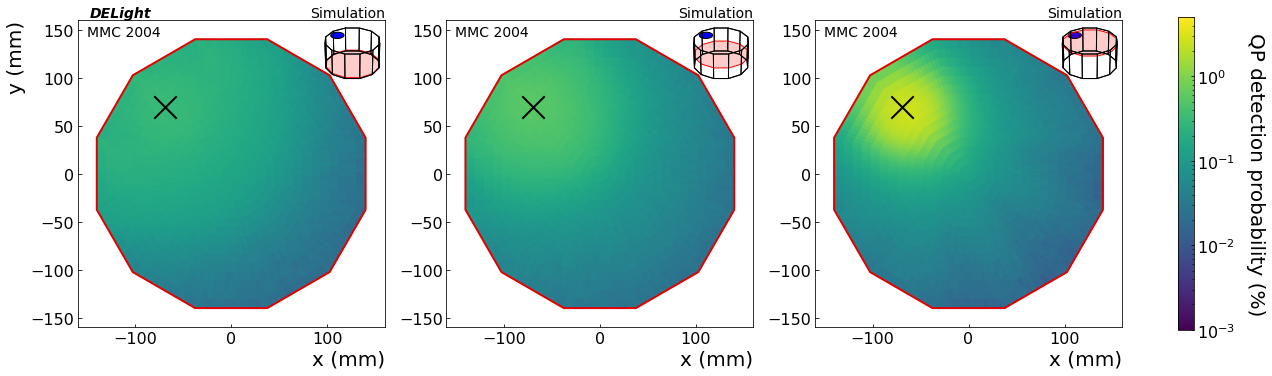

In [162]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

bins_z = np.linspace(-1953., -1713., 26)
MMC_index = 4
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

for iz, z in enumerate([1, 11, 23]):
    plt.sca(axs[iz])
    im, ax = pce.pb[MMC_index].plot_distribution(z, ax=axs[iz], normalize_area=False, cmap='viridis', vmin=1e-3, vmax=5., 
                                                scale=100., log_scale=True)
    plt.scatter(*MMC_position[MMC_index][:2], c='xkcd:black', marker='x', s=500, zorder=10)

    ax.set_xlim(-160, 160), ax.set_ylim(-160, 160), 
    ax.set_xlabel('x (mm)', ha='right', x=1.0)
    if (iz == 0): ax.set_ylabel('y (mm)', ha='right', y=1.0)
    # plt.title(f"MMC 2004")
    ax.add_patch(PathPatch(polygon, facecolor='None', edgecolor='xkcd:red', lw=2.))
    ax.set_aspect(1.)

cbar = fig.colorbar(im, ax=axs, fraction=0.014)
cbar.set_label(r'QP detection probability (%)', rotation=270, labelpad=30)
ut.display_delight_text(axs[0], x0=0.04, y0=1.045)

# Add 3D plot inset
for iz, z in enumerate([1, 11, 23]):
    ax = axs[iz]
    ut.display_text(ax, 'MMC 2004', x0=0.03, y0=0.985)
    ut.display_text(ax, 'Simulation', x0=1.0, y0=1.045, ha='right')
    section_vertices = [(x, y, 0.5 * (bins_z[z] + bins_z[z+1])) for (x,y) in vertices]
    new_coords = fig.transFigure.inverted().transform(ax.transData.transform([125, 125]))
    inset_ax = fig.add_axes([new_coords[0] - 0.075,  # x-position of inset
                             new_coords[1] - 0.16,   # y-position of inset
                             0.15, 0.15],           # width and height
                            projection='3d', facecolor='None')

    # Draw the MMC
    circle_vertices = np.column_stack([35 * np.cos(np.linspace(0, 2 * np.pi, 100)) + MMC_position[N_MMC - MMC_index][0], 
                                       35 * np.sin(np.linspace(0, 2 * np.pi, 100)) + MMC_position[N_MMC - MMC_index][1],
                                       -1700.5 * np.ones(100)])
    inset_ax.add_collection3d(Poly3DCollection([circle_vertices], facecolors='blue', edgecolor='black', alpha=1))

    # Draw the polyhedron
    inset_ax.add_collection3d(Poly3DCollection(faces, facecolors='white', edgecolor='black', alpha=0))
    inset_ax.add_collection3d(Poly3DCollection([section_vertices], facecolors='red', edgecolor='red', alpha=0.2))

    # Adjust inset plot limits and remove background
    inset_ax.set_xlim(-140, 140)
    inset_ax.set_ylim(-140, 140)
    inset_ax.set_zlim(-2000, -1650)
    inset_ax.axis('off')  # Turn off axes background

plt.savefig(os.path.join('', 'PCE_MMC_2004.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'PCE_MMC_2004.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show()

## Traces

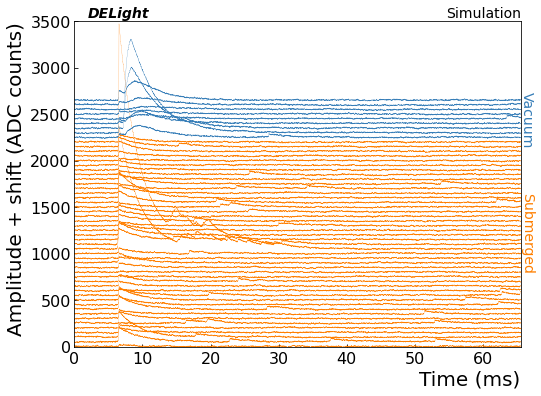

In [19]:
traces = np.load('trace_NR_1.npy')
fig, ax = plt.subplots(figsize=(8, 6))
t_edges = np.linspace(0., 65536000.0, 16385)
times = 0.5 * (t_edges[1:] + t_edges[:-1]) * 1e-6

for i in range(N_MMC):
    if i > 44:
        plt.plot(times, traces[0][i] + i * 50, c=colors[0], lw=0.2)
    else:
        plt.plot(times, traces[0][i] + i * 50, c=colors[1], lw=0.2)
        
ut.display_delight_text(ax, x0=0.03, y0=1.045)
# ut.display_text(ax, '(own work)', x0=0.175, y0=1.045)
ut.display_text(ax, 'Simulation', x0=1.0, y0=1.045, ha='right')

ax.text(1.03, 0.7, 'Vacuum', transform=ax.transAxes,
        fontsize=14, color=colors[0], alpha=1.0,
        ha='right', va='center', rotation=270, zorder=10)
ax.text(1.03, 0.35, 'Submerged', transform=ax.transAxes,
        fontsize=14, color=colors[1], alpha=1.0,
        ha='right', va='center', rotation=270, zorder=10)

ax.set_xlim(0, times.max()), ax.set_xlabel('Time (ms)', x=1.0, ha='right')
ax.set_ylim(-10, 3500), ax.set_ylabel('Amplitude + shift (ADC counts)', y=1.0, ha='right')

# plt.savefig(os.path.join('', 'simulated_trace_1_er.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'simulated_trace_3_nr.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show()

## Photon arrival time

In [2]:
import pandas as pd
import uproot

list_vecStr = "type creaProc depProc creaVol parent_type"

def load_root(file_name, list_vecstr=list_vecStr, pandas=True, _library="np"):
    
    with uproot.open(file_name) as file:
        tree = file["Events"]
        df = tree.arrays(tree.keys(), library=_library, array_cache=None)
        for field in list_vecstr.split(' '):
            df[field] = np.array([np.array([np.array(y) for y in x.split('\n')]) for (i, x) in enumerate(df[field])], dtype='O')
    l = [df[k] for k in df.keys()]
    df = np.array(list(map(tuple, zip(*l))), dtype=[(k, df[k].dtype) for k in df.keys()])
    if pandas:
        return pd.DataFrame(df).sort_values('event_ID').reset_index(drop=True)
    else:
        return df

In [3]:
df = load_root('/home/ws/ks0116/software/DELight_MC/optical_simulation.root')

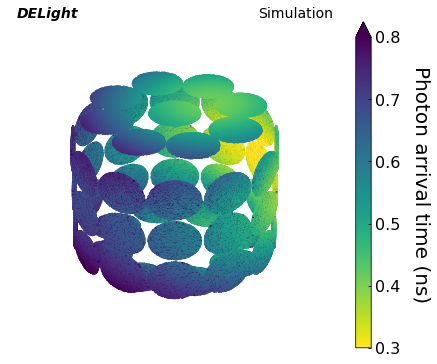

In [9]:
x = df[df.MMC_index > -1].x.str[-1]
y = df[df.MMC_index > -1].y.str[-1]
z = df[df.MMC_index > -1].z.str[-1]
t = df[df.MMC_index > -1].t.str[-1]

# Create a figure
fig = plt.figure(figsize=(8, 6))

# Add 3D axes
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(x, y, z, c=t, cmap='viridis_r', s=1, vmin=0.3, vmax=0.8)

# Remove axes
ax.axis('off')

# Add a color bar to show the z-values
cbar = fig.colorbar(scatter, ax=ax, extend='max', fraction=0.05)
cbar.set_label(r'Photon arrival time (ns)', rotation=270, labelpad=30)
ut.display_delight_text(ax, x0=0.03, y0=1.045)
ut.display_text(ax, 'Simulation', x0=1.0, y0=1.045, ha='right')

ax.set_xlim(min(x), max(x))  # Adjust these values as needed to zoom in
ax.set_ylim(min(y), max(y))  # Replace min(y) and max(y) with specific ranges
ax.set_zlim(min(z), max(z))  # Replace min(z) and max(z) with specific ranges

# Show the plot
# plt.savefig(os.path.join('', 'photon_arrival_time.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'photon_arrival_time.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show();

## Signal partitioning plots

In [2]:
def get_files_in(path, contains=''):
    return [os.path.join(path, l) for l in os.listdir(path) if contains in l]

# Define a function to add a mirrored y-axis
def add_mirrored_yaxis(ax):
    ax_right = ax.twinx()
    ax_right.set_ylim(ax.get_ylim())  # Mirror the limits from the left axis
    return ax_right

ER done, doing NR


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


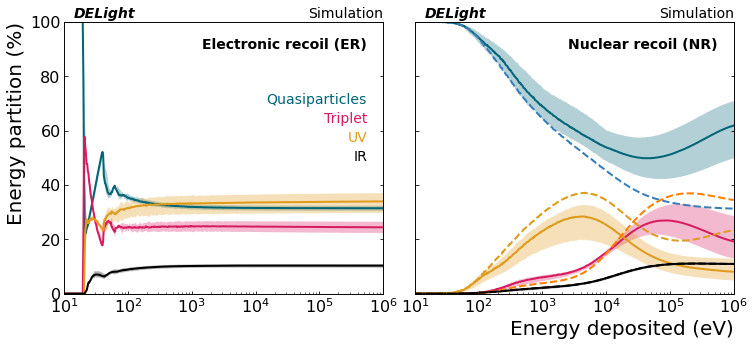

In [3]:
import matplotlib.ticker as mticker
import numpy as np
import os

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)
plt.subplots_adjust(wspace=0.1)

E = np.geomspace(10, 1e6, 500)
E_unc = np.geomspace(10, 1e6, 300)

# First subplot for ER
plt.sca(axs[0])
dir_files = '/kalinka/storage/darkmatter/DELight/share/output/signal_partition/ER_final/'

files = get_files_in(dir_files + 'main')
E_fraction_mean = np.zeros((len(E), 4))
for index in range(len(E)):
    try:
        tmp_c = np.concatenate([np.load(l) for l in files if f'_{index}_' in l])
        tmp = np.mean(tmp_c, axis=0)
    except:
        continue
    E_fraction_mean[index] = tmp[:4]

for clr, lbl, frc in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), 'Phonons Triplet UV IR'.split(), E_fraction_mean.T):
    plt.plot(E, frc/E*100., color=clr, marker='None', ls='-', lw=2.)
    
E_ER_lower = np.ones((len(E_unc), 4)) * np.inf
E_ER_upper = np.zeros((len(E_unc), 4))
for v in ['ionization', 'excitation']:
    files = get_files_in(dir_files + v)
    for w in ['plus', 'minus']:
        for index in range(len(E_unc)):
            try:
                tmp_c = np.concatenate([np.load(l) for l in files if w in l and f'_{index}_' in l])
                tmp = np.mean(tmp_c, axis=0)
            except KeyboardInterrupt:
                break
            except:
                continue
            E_ER_upper[index] = np.max(np.vstack([tmp[:4], E_ER_upper[index]]), axis=0)
            E_ER_lower[index] = np.min(np.vstack([tmp[:4], E_ER_lower[index]]), axis=0)

for clr, up, low in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), E_ER_upper.T, E_ER_lower.T):
    plt.fill_between(E_unc, low/E_unc*100., up/E_unc*100., color=clr, alpha=0.3, ls='None', lw=0.)

# axs[0].set_xlabel('Energy deposited (eV)', ha='right', x=1.0)
axs[0].set_ylabel('Energy partition (%)', ha='right', y=1.0)
plt.xlim(10, 1e6), plt.ylim(0, 100)
plt.semilogx()

plt.text(0.95, 0.9, 'Electronic recoil (ER)', color='xkcd:black', weight='bold', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.7, 'Quasiparticles', color='#006477', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.63, 'Triplet', color='#D81B60', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.56, 'UV', color='#DF9B1B', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.49, 'IR', color='xkcd:black', transform=plt.gca().transAxes, ha='right', fontsize=14.)
ut.display_delight_text(axs[0], x0=0.03, y0=1.055)
ut.display_text(axs[0], 'Simulation', x0=1.0, y0=1.055, ha='right')

# Add mirrored y-axis on the right for the first subplot
ax_right = add_mirrored_yaxis(axs[0])
ax_right.set_yticklabels([])

print('ER done, doing NR')
# Second plot for NR
plt.sca(axs[1])
dir_files = '/kalinka/storage/darkmatter/DELight/share/output/signal_partition/NR_final/'

E_fraction_mean = np.zeros((len(E), 8))
files = get_files_in(dir_files + 'main')
for index in range(len(E)):
    try:
        tmp_c = np.concatenate([np.load(l) for l in files if f'_{index}_' in l and not '_lin_' in l])
        tmp = np.mean(tmp_c, axis=0)
    except:
        continue
    E_fraction_mean[index] = tmp[:8]

for clr, lbl, frc in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), 'Phonons Triplet UV IR'.split(), E_fraction_mean.T):
    plt.plot(E, frc/E*100., color=clr, marker='None', ls='-', lw=2.)
for clr, frc in zip('C0 C1 #DF9B1B xkcd:black'.split(), E_fraction_mean[:,4:].T):
    plt.plot(E, frc/E*100., color=clr, marker='None', ls='--', lw=2.)

E_NR_lower = np.ones((len(E_unc), 4)) * np.inf
E_NR_upper = np.zeros((len(E_unc), 4))

for v in ['excitation', 'ionization', 'charge_exchange', 'penning_gamma']:
    files = get_files_in(dir_files + v)
    for w in ['plus', 'minus']:
        files_tmp = [l for l in files if w in l]
        for index in range(len(E_unc)):
            try:
                tmp_c = np.concatenate([np.load(l) for l in files_tmp if f'_{index}_' in l])
                tmp = np.mean(tmp_c, axis=0)
            except:
                continue
            E_NR_upper[index] = np.max(np.vstack([tmp[:4], E_NR_upper[index]]), axis=0)
            E_NR_lower[index] = np.min(np.vstack([tmp[:4], E_NR_lower[index]]), axis=0)

files = get_files_in(dir_files + 'penning_dt')
for w in ['t100ns', 't10ns']:
    files_tmp = [l for l in files if w in l]
    for index in range(len(E_unc)):
        try:
            tmp_c = np.concatenate([np.load(l) for l in files_tmp if f'_{index}_' in l])
            tmp = np.mean(tmp_c, axis=0)
        except:
            continue
        E_NR_upper[index] = np.max(np.vstack([tmp[:4], E_NR_upper[index]]), axis=0)
        E_NR_lower[index] = np.min(np.vstack([tmp[:4], E_NR_lower[index]]), axis=0)

for clr, up, low in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), E_NR_upper.T, E_NR_lower.T):
    plt.fill_between(E_unc, low/E_unc*100., up/E_unc*100., color=clr, alpha=0.3, ls='None', lw=0.)

plt.text(0.95, 0.9, 'Nuclear recoil (NR)', color='xkcd:black', weight='bold', transform=plt.gca().transAxes, ha='right', fontsize=14.)
axs[1].set_xlabel('Energy deposited (eV)', ha='right', x=1.0)
ut.display_delight_text(axs[1], x0=0.03, y0=1.055)
ut.display_text(axs[1], 'Simulation', x0=1.0, y0=1.055, ha='right')
plt.ylim(0, 100)
plt.xlim(10, 1e6)
plt.semilogx()

# Add mirrored y-axis on the right for the second subplot
ax_right = add_mirrored_yaxis(axs[1])
ax_right.set_yticklabels([])
# ax_right.set_ylabel(axs[0].get_ylabel(), ha='left', va='bottom', y=1.0, rotation=270)  # Mirror the label from the left axis

axs[0].xaxis.set_minor_locator(mticker.LogLocator(base=10,subs=np.arange(2, 9.5)))
axs[1].xaxis.set_minor_locator(mticker.LogLocator(base=10,subs=np.arange(2, 9.5)))

plt.savefig(os.path.join('', 'signal_partitioning_single_labels.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'signal_partitioning_single_labels.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show();

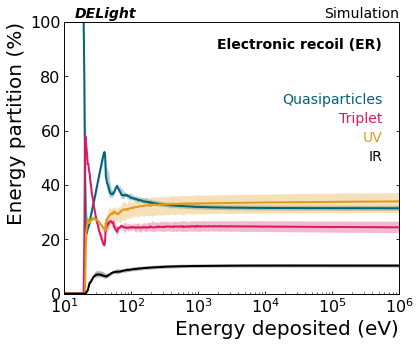

In [45]:
import matplotlib.ticker as mticker
import numpy as np
import os

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 1, figsize=(6,5))

E = np.geomspace(10, 1e6, 500)
E_unc = np.geomspace(10, 1e6, 300)

# First subplot for ER
dir_files = '/kalinka/storage/darkmatter/DELight/share/output/signal_partition/ER_final/'

files = get_files_in(dir_files + 'main')
E_fraction_mean = np.zeros((len(E), 4))
for index in range(len(E)):
    try:
        tmp_c = np.concatenate([np.load(l) for l in files if f'_{index}_' in l])
        tmp = np.mean(tmp_c, axis=0)
    except:
        continue
    E_fraction_mean[index] = tmp[:4]

for clr, lbl, frc in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), 'Phonons Triplet UV IR'.split(), E_fraction_mean.T):
    plt.plot(E, frc/E*100., color=clr, marker='None', ls='-', lw=2.)
    
E_ER_lower = np.ones((len(E_unc), 4)) * np.inf
E_ER_upper = np.zeros((len(E_unc), 4))
for v in ['ionization', 'excitation']:
    files = get_files_in(dir_files + v)
    for w in ['plus', 'minus']:
        for index in range(len(E_unc)):
            try:
                tmp_c = np.concatenate([np.load(l) for l in files if w in l and f'_{index}_' in l])
                tmp = np.mean(tmp_c, axis=0)
            except KeyboardInterrupt:
                break
            except:
                continue
            E_ER_upper[index] = np.max(np.vstack([tmp[:4], E_ER_upper[index]]), axis=0)
            E_ER_lower[index] = np.min(np.vstack([tmp[:4], E_ER_lower[index]]), axis=0)

for clr, up, low in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), E_ER_upper.T, E_ER_lower.T):
    plt.fill_between(E_unc, low/E_unc*100., up/E_unc*100., color=clr, alpha=0.3, ls='None', lw=0.)

axs.set_xlabel('Energy deposited (eV)', ha='right', x=1.0)
axs.set_ylabel('Energy partition (%)', ha='right', y=1.0)
plt.xlim(10, 1e6), plt.ylim(0, 100)
plt.semilogx()

plt.text(0.95, 0.9, 'Electronic recoil (ER)', color='xkcd:black', weight='bold', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.7, 'Quasiparticles', color='#006477', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.63, 'Triplet', color='#D81B60', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.56, 'UV', color='#DF9B1B', transform=plt.gca().transAxes, ha='right', fontsize=14.)
plt.text(0.95, 0.49, 'IR', color='xkcd:black', transform=plt.gca().transAxes, ha='right', fontsize=14.)
ut.display_delight_text(axs, x0=0.03, y0=1.055)
ut.display_text(axs, 'Simulation', x0=1.0, y0=1.055, ha='right')

# Add mirrored y-axis on the right for the first subplot
ax_right = add_mirrored_yaxis(axs)
ax_right.set_yticklabels([])

axs.xaxis.set_minor_locator(mticker.LogLocator(base=10,subs=np.arange(2, 9.5)))

plt.savefig(os.path.join('', 'electronic_recoil_partition.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'electronic_recoil_partition.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show();

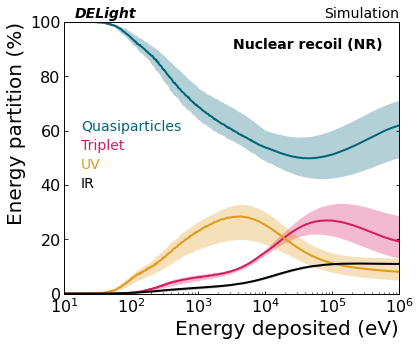

In [5]:
import matplotlib.ticker as mticker
import numpy as np
import os

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 1, figsize=(6,5))

E = np.geomspace(10, 1e6, 500)
E_unc = np.geomspace(10, 1e6, 300)

dir_files = '/kalinka/storage/darkmatter/DELight/share/output/signal_partition/NR_final/'

E_fraction_mean = np.zeros((len(E), 8))
files = get_files_in(dir_files + 'main')
for index in range(len(E)):
    try:
        tmp_c = np.concatenate([np.load(l) for l in files if f'_{index}_' in l and not '_lin_' in l])
        tmp = np.mean(tmp_c, axis=0)
    except:
        continue
    E_fraction_mean[index] = tmp[:8]

for clr, lbl, frc in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), 'Phonons Triplet UV IR'.split(), E_fraction_mean.T):
    plt.plot(E, frc/E*100., color=clr, marker='None', ls='-', lw=2.)
# for clr, frc in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), E_fraction_mean[:,4:].T):
    # plt.plot(E, frc/E*100., color=clr, marker='None', ls='--', lw=2.)

E_NR_lower = np.ones((len(E_unc), 4)) * np.inf
E_NR_upper = np.zeros((len(E_unc), 4))

for v in ['excitation', 'ionization', 'charge_exchange', 'penning_gamma']:
    files = get_files_in(dir_files + v)
    for w in ['plus', 'minus']:
        files_tmp = [l for l in files if w in l]
        for index in range(len(E_unc)):
            try:
                tmp_c = np.concatenate([np.load(l) for l in files_tmp if f'_{index}_' in l])
                tmp = np.mean(tmp_c, axis=0)
            except:
                continue
            E_NR_upper[index] = np.max(np.vstack([tmp[:4], E_NR_upper[index]]), axis=0)
            E_NR_lower[index] = np.min(np.vstack([tmp[:4], E_NR_lower[index]]), axis=0)

files = get_files_in(dir_files + 'penning_dt')
for w in ['t100ns', 't10ns']:
    files_tmp = [l for l in files if w in l]
    for index in range(len(E_unc)):
        try:
            tmp_c = np.concatenate([np.load(l) for l in files_tmp if f'_{index}_' in l])
            tmp = np.mean(tmp_c, axis=0)
        except:
            continue
        E_NR_upper[index] = np.max(np.vstack([tmp[:4], E_NR_upper[index]]), axis=0)
        E_NR_lower[index] = np.min(np.vstack([tmp[:4], E_NR_lower[index]]), axis=0)

for clr, up, low in zip('#006477 #D81B60 #DF9B1B xkcd:black'.split(), E_NR_upper.T, E_NR_lower.T):
    plt.fill_between(E_unc, low/E_unc*100., up/E_unc*100., color=clr, alpha=0.3, ls='None', lw=0.)

plt.text(0.95, 0.9, 'Nuclear recoil (NR)', color='xkcd:black', weight='bold', transform=plt.gca().transAxes, ha='right', fontsize=14.)
axs.set_ylabel('Energy partition (%)', ha='right', y=1.0)
axs.set_xlabel('Energy deposited (eV)', ha='right', x=1.0)
ut.display_delight_text(axs, x0=0.03, y0=1.055)
ut.display_text(axs, 'Simulation', x0=1.0, y0=1.055, ha='right')
plt.ylim(0, 100)
plt.xlim(10, 1e6)
plt.semilogx()

plt.text(0.05, 0.6, 'Quasiparticles', color='#006477', transform=plt.gca().transAxes, ha='left', fontsize=14.)
plt.text(0.05, 0.53, 'Triplet', color='#D81B60', transform=plt.gca().transAxes, ha='left', fontsize=14.)
plt.text(0.05, 0.46, 'UV', color='#DF9B1B', transform=plt.gca().transAxes, ha='left', fontsize=14.)
plt.text(0.05, 0.39, 'IR', color='xkcd:black', transform=plt.gca().transAxes, ha='left', fontsize=14.)

# Add mirrored y-axis on the right for the second subplot
ax_right = add_mirrored_yaxis(axs)
ax_right.set_yticklabels([])
# ax_right.set_ylabel(axs[0].get_ylabel(), ha='left', va='bottom', y=1.0, rotation=270)  # Mirror the label from the left axis

axs.xaxis.set_minor_locator(mticker.LogLocator(base=10,subs=np.arange(2, 9.5)))

plt.savefig(os.path.join('', 'nuclear_recoil_partitioning_no_dashed.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'nuclear_recoil_partitioning_no_dashed.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show();

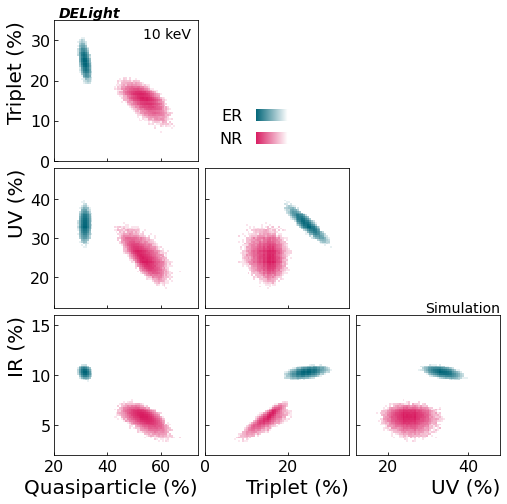

In [29]:
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import LinearSegmentedColormap, LogNorm

def create_custom_colormap(base_color, final_color):
    cmap = LinearSegmentedColormap.from_list(
        'custom_cmap', [(0, base_color), (1, final_color)]
    )
    return cmap

# Load data
dir_data = '/kalinka/storage/darkmatter/DELight/share/output/signal_partition/NR_final/main'
data_nr = np.concatenate([np.load(f) for f in get_files_in(dir_data, '_300_')])
dir_data = '/kalinka/storage/darkmatter/DELight/share/output/signal_partition/ER_final/main'
data_er = np.concatenate([np.load(f) for f in get_files_in(dir_data, '_300_')])

fig, axs = plt.subplots(3, 3, figsize=(8,8), sharex='col', sharey='row')
plt.subplots_adjust(hspace=0.05, wspace=0.05)

er_cmap = create_custom_colormap('xkcd:white', '#006477')
nr_cmap = create_custom_colormap('xkcd:white', '#D81B60')
cmaps_gradients = {'ER': er_cmap(np.linspace(1, 0, 256)), 'NR': nr_cmap(np.linspace(1, 0, 256))}
patches_cmaps_gradients = []
for cmap_name, cmap_colors in cmaps_gradients.items():
    patches_cmaps_gradients.append([patches.Patch(facecolor=c, edgecolor=c, label=cmap_name) for c in cmap_colors])

E_tot = np.sum(data_er[:,:4], axis=1)[0]
labels = ['Quasiparticle (%)', 'Triplet (%)', 'UV (%)', 'IR (%)']
bins = [np.linspace(20, 74, 76), np.linspace(0, 35, 76), np.linspace(12, 48, 76), np.linspace(2, 16, 76)]
is_rast = True

plt.sca(axs[0,0])
binning = (bins[0], bins[1])
plt.hist2d(data_nr[:,0] / E_tot * 100, data_nr[:,1] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=nr_cmap, rasterized=is_rast, label='NR')
plt.hist2d(data_er[:,0] / E_tot * 100, data_er[:,1] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=er_cmap, rasterized=is_rast, label='ER')
plt.ylabel(labels[1], ha='right', y=1.0)
ut.display_delight_text(axs[0,0], x0=0.03, y0=1.1)
ut.display_text(axs[0,0], '10 keV', x0=0.95, y0=0.95, ha='right')

plt.sca(axs[1,0])
binning = (bins[0], bins[2])
plt.hist2d(data_nr[:,0] / E_tot * 100, data_nr[:,2] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=nr_cmap, rasterized=is_rast)
plt.hist2d(data_er[:,0] / E_tot * 100, data_er[:,2] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=er_cmap, rasterized=is_rast)
plt.ylabel(labels[2], ha='right', y=1.0)

plt.sca(axs[1,1])
binning = (bins[1], bins[2])
plt.hist2d(data_nr[:,1] / E_tot * 100, data_nr[:,2] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=nr_cmap, rasterized=is_rast)
plt.hist2d(data_er[:,1] / E_tot * 100, data_er[:,2] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=er_cmap, rasterized=is_rast)

plt.sca(axs[2,0])
binning = (bins[0], bins[3])
plt.hist2d(data_nr[:,0] / E_tot * 100, data_nr[:,3] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=nr_cmap, rasterized=is_rast)
plt.hist2d(data_er[:,0] / E_tot * 100, data_er[:,3] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=er_cmap, rasterized=is_rast)
plt.xlabel(labels[0], ha='right', x=1.0), plt.ylabel(labels[3], ha='right', y=1.0)

plt.sca(axs[2,1])
binning = (bins[1], bins[3])
plt.hist2d(data_nr[:,1] / E_tot * 100, data_nr[:,3] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=nr_cmap, rasterized=is_rast)
plt.hist2d(data_er[:,1] / E_tot * 100, data_er[:,3] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=er_cmap, rasterized=is_rast)
plt.xlabel(labels[1], ha='right', x=1.0)

plt.sca(axs[2,2])
binning = (bins[2], bins[3])
plt.hist2d(data_nr[:,2] / E_tot * 100, data_nr[:,3] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=nr_cmap, rasterized=is_rast)
plt.hist2d(data_er[:,2] / E_tot * 100, data_er[:,3] / E_tot * 100, bins=binning, norm=LogNorm(), cmap=er_cmap, rasterized=is_rast)
plt.xlabel(labels[2], ha='right', x=1.0)
ut.display_text(axs[2,2], 'Simulation', x0=1.0, y0=1.1, ha='right')

plt.sca(axs[0,1])
plt.legend(handles=patches_cmaps_gradients, labels=cmaps_gradients.keys(), handler_map={list: HandlerTuple(ndivide=None, pad=0)}, markerfirst=False, loc='lower left')
plt.axis('off')

plt.delaxes(axs[0,2])
plt.delaxes(axs[1,2])

plt.savefig(os.path.join('', 'signal_10keV_distribution.pdf'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.savefig(os.path.join('', 'signal_10keV_distribution.png'), bbox_inches='tight', transparent=True, pad_inches=0.1)
plt.show();